# Import needed packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-talk')
plt.rcParams.update({'figure.dpi': 120,'figure.figsize': (6,4)})                    

from pyQME.spectral_density import SpectralDensity
from pyQME.tensors.markov import RedfieldTensor
from pyQME.linear_spectra import SecularSpectraCalculator
from pyQME.utils import overdamped_brownian,underdamped_brownian,get_timeaxis,wn2ips,gauss_pulse,calc_rho0_from_overlap

# Define the system

**Hamiltonian (1/cm)**

In [2]:
nchrom = 2 #number of chromophores

coupling = 100
E0 = 10000
energy_gap = 500
H = np.zeros((nchrom,nchrom)) #hamiltonian

H[0] = np.asarray([E0      ,coupling     ])
H[1] = np.asarray([coupling,E0+energy_gap])

In [3]:
H

array([[10000.,   100.],
       [  100., 10500.]])

**Transition dipoles (Debye)**

In [4]:
dipoles = np.ones([nchrom,3])

**Temperature (Kelvin)**

In [5]:
temp = 298

**Spectral density**

In [6]:
freq_axis_SD = np.arange(0.1,4000,0.1)

In [7]:
SD_data = overdamped_brownian(freq_axis_SD,30,37)
SD_data = SD_data + underdamped_brownian(freq_axis_SD,5,50,518)

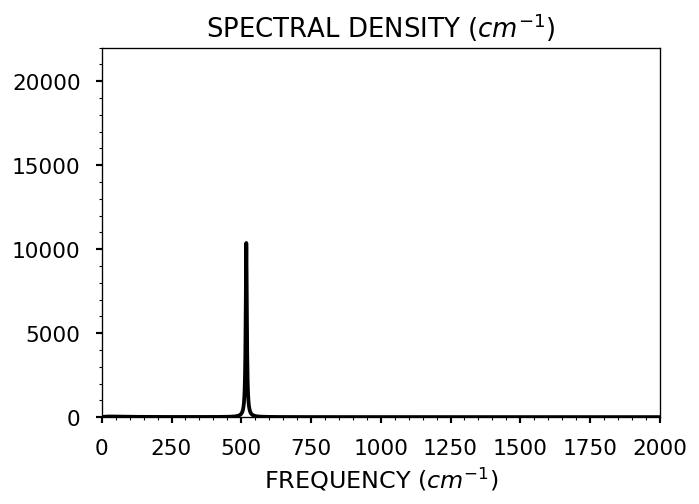

In [8]:
plt.plot(freq_axis_SD,SD_data,color='black');
plt.xlim(0,2000);
plt.ylim(0,22000)
plt.title('SPECTRAL DENSITY ($cm^{-1}$)');
plt.xlabel('FREQUENCY ($cm^{-1}$)');
plt.minorticks_on()

In [9]:
SD_obj = SpectralDensity(freq_axis_SD,SD_data,temperature=temp)

**Time axis (cm)**

In [10]:
energies = np.diag(H)
time_axis = get_timeaxis(SD_obj.Reorg,energies,5)
SD_obj.time = time_axis

**Relaxation Tensor**

In [11]:
rel_tens_obj = RedfieldTensor(H,SD_obj)

# Excited state dynamics

**Time axis**

In [12]:
time_axis_ps = np.arange(0,3,0.001)     #to be saved
time_axis_cm = time_axis_ps*wn2ips

**Initial density matrix**

In [13]:
#absorption spectrum of each exciton

lin_spec_obj = SecularSpectraCalculator(rel_tens_obj)
freq_axis,OD_a = lin_spec_obj.calc_abs_OD_a(dipoles)

In [14]:
#generate the pump pulse
pump = gauss_pulse(freq_axis,10200,100,2000000)

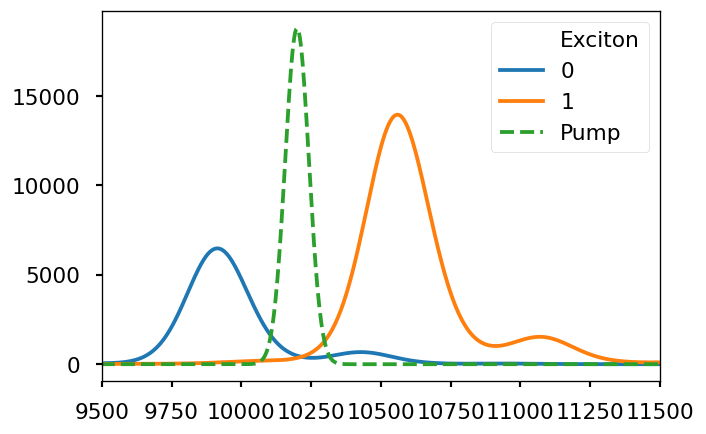

In [15]:
#visualize the overlap
plt.plot([],[],color='white',label='Exciton')
plt.plot(freq_axis,OD_a.T,label=range(nchrom))
plt.plot(freq_axis,pump,ls='--',label='Pump')
plt.legend();
plt.xlim(9500,11500);

In [16]:
#calculate the overlap and the initial density matrix
rho_0_exc = calc_rho0_from_overlap(freq_axis,OD_a,pump)

#normalize
rho_0_exc = rho_0_exc/rho_0_exc.trace()

**Propagate**

In [17]:
rho_t_exc = rel_tens_obj.propagate(rho_0_exc,time_axis_cm)    #to be saved

#convert to site basis
rho_t_site = rel_tens_obj.transform_back(rho_t_exc)    #to be saved

# Check the results

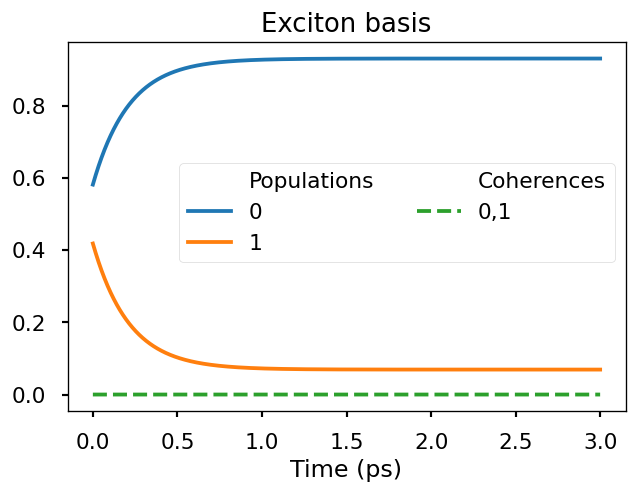

In [18]:
plt.title('Exciton basis')
plt.plot([],[],color='white',label='Populations')
plt.plot(time_axis_ps,rho_t_exc[:,0,0].real,label = '0')
plt.plot(time_axis_ps,rho_t_exc[:,1,1].real,label = '1')
plt.plot([],[],color='white',label='Coherences')
plt.plot(time_axis_ps,rho_t_exc[:,0,1].real,label = '0,1',ls='--')
plt.legend(ncol=2,fontsize = 13,bbox_to_anchor = (1.0,0.7))
plt.xlabel('Time (ps)');

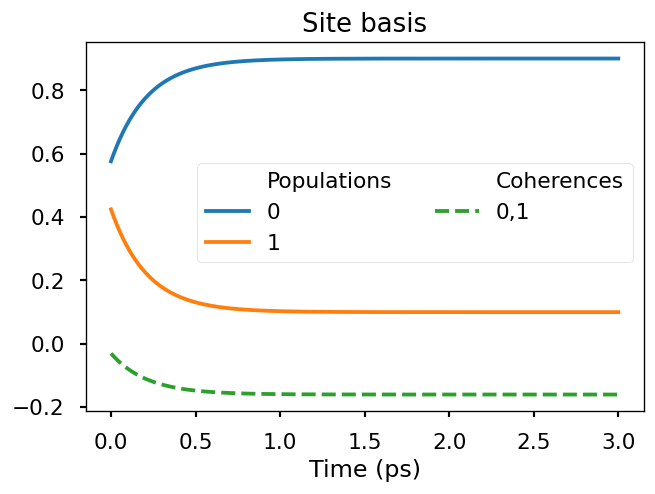

In [19]:
plt.title('Site basis')
plt.plot([],[],color='white',label='Populations')
plt.plot(time_axis_ps,rho_t_site[:,0,0].real,label = '0')
plt.plot(time_axis_ps,rho_t_site[:,1,1].real,label = '1')
plt.plot([],[],color='white',label='Coherences')
plt.plot(time_axis_ps,rho_t_site[:,0,1].real,label = '0,1',ls='--')
plt.legend(ncol=2,fontsize = 13,bbox_to_anchor = (1.0,0.7))
plt.xlabel('Time (ps)');

**Save to file for future pump-probe spectra calculations**

In [20]:
#select delay time of interest
time_list = [0.,2.9]
time_list_idx = [min(range(len(time_axis_ps)), key=lambda i: abs(time_axis_ps[i]-time)) for time in time_list]
mask = np.zeros(time_axis_ps.shape,bool)
mask[time_list_idx] = True
time_axis_ps_masked = time_axis_ps[mask]
rho_t_site_masked = rho_t_site[mask]

In [21]:
rho_t_site_masked_ = rho_t_site_masked.reshape((time_axis_ps_masked.size,nchrom**2))
data = np.append(np.asarray([time_axis_ps_masked]).T,rho_t_site_masked_,axis=1).real
np.savetxt('excited_state_dynamics.dat',data,fmt='%3.7f')